In [1]:
# Cell 1: Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (confusion_matrix, classification_report,
                             roc_auc_score, roc_curve, accuracy_score, precision_score,
                             recall_score, f1_score)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

sns.set(style="whitegrid")
%matplotlib inline


In [2]:
# Cell 2: Load dataset
import seaborn as sns
df = sns.load_dataset('titanic')  # convenient built-in version
print(df.shape)
df.head()


(891, 15)


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [3]:
# Cell 3: Quick dataset description
print("Columns:", df.columns.tolist())
print("Target distribution (survived):")
print(df['survived'].value_counts(dropna=False))
df.info()


Columns: ['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'class', 'who', 'adult_male', 'deck', 'embark_town', 'alive', 'alone']
Target distribution (survived):
survived
0    549
1    342
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive

In [4]:
# Cell 4: Prepare a working dataframe
data = df[['survived','pclass','sex','age','sibsp','parch','fare','embarked']].copy()
data.shape


(891, 8)

In [5]:
# Cell 5: Examine missingness & basic stats
print(data.isna().sum())
data.describe(include='all')


survived      0
pclass        0
sex           0
age         177
sibsp         0
parch         0
fare          0
embarked      2
dtype: int64


,survived,pclass,sex,age,sibsp,parch,fare,embarked
count,891.000000,891.000000,891,714.000000,891.000000,891.000000,891.000000,889
unique,NaN,NaN,2,NaN,NaN,NaN,NaN,3
top,NaN,NaN,male,NaN,NaN,NaN,NaN,S
freq,NaN,NaN,577,NaN,NaN,NaN,NaN,644
mean,0.383838,2.308642,NaN,29.699118,0.523008,0.381594,32.204208,NaN
std,0.486592,0.836071,NaN,14.526497,1.102743,0.806057,49.693429,NaN
min,0.000000,1.000000,NaN,0.420000,0.000000,0.000000,0.000000,NaN
25%,0.000000,2.000000,NaN,20.125000,0.000000,0.000000,7.910400,NaN
50%,0.000000,3.000000,NaN,28.000000,0.000000,0.000000,14.454200,NaN
75%,1.000000,3.000000,NaN,38.000000,1.000000,0.000000,31.000000,NaN


In [6]:
# Cell 6: Split X/y first (so transformations fit on train only)
X = data.drop('survived', axis=1)
y = data['survived']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (712, 7) Test shape: (179, 7)


In [7]:
# Cell 7: Preprocessing pipeline
numeric_features = ['age','sibsp','parch','fare']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_features = ['sex','embarked','pclass']  # pclass treated as categorical
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


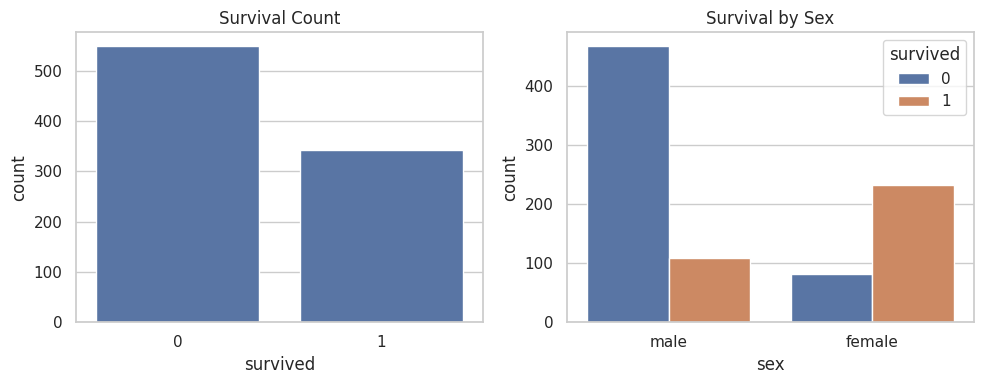

In [8]:
# Cell 8: EDA plots
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.countplot(x='survived', data=data)
plt.title('Survival Count')

plt.subplot(1,2,2)
sns.countplot(x='sex', hue='survived', data=data)
plt.title('Survival by Sex')
plt.tight_layout()


Text(0.5, 1.0, 'Age distribution: Survived vs Died')

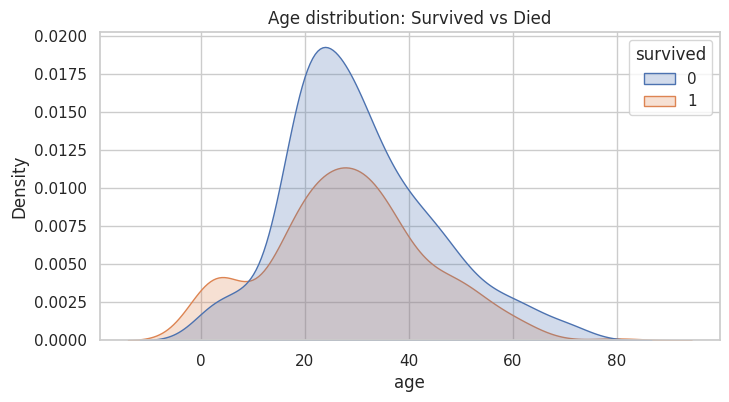

In [9]:
# Cell 9: Age distribution by survival
plt.figure(figsize=(8,4))
sns.kdeplot(data=data, x='age', hue='survived', fill=True)
plt.title('Age distribution: Survived vs Died')


Text(0.5, 1.0, 'Survival by Passenger Class')

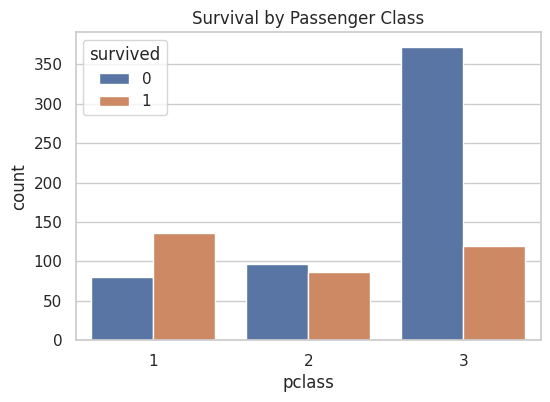

In [10]:
# Cell 10: Pclass vs Survival
plt.figure(figsize=(6,4))
sns.countplot(x='pclass', hue='survived', data=data)
plt.title('Survival by Passenger Class')


Text(0.5, 1.0, 'Correlation matrix (numeric)')

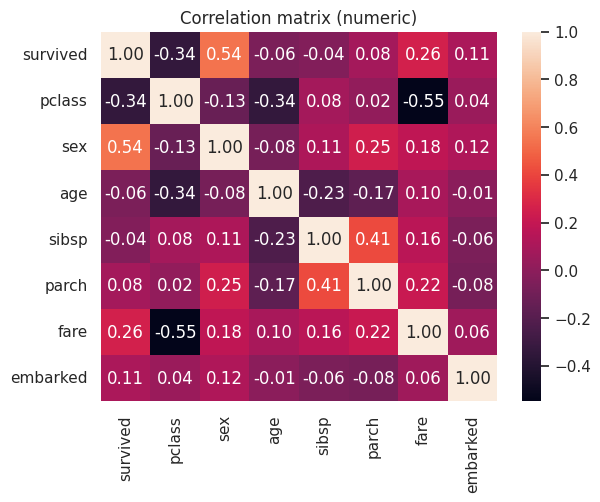

In [11]:
# Cell 11: Correlation heatmap (after basic numeric fill)
corr_df = data.copy()
corr_df['age'] = corr_df['age'].fillna(corr_df['age'].median())
corr_df['fare'] = corr_df['fare'].fillna(corr_df['fare'].median())
corr_df['sex'] = corr_df['sex'].map({'male':0,'female':1})
corr_df['embarked'] = corr_df['embarked'].map({'S':0,'C':1,'Q':2})
sns.heatmap(corr_df.corr(), annot=True, fmt=".2f")
plt.title('Correlation matrix (numeric)')


In [12]:
# Cell 12: Build pipelines for models
from sklearn.pipeline import make_pipeline

# Logistic Regression pipeline
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression(solver='liblinear', random_state=42))
])

# Random Forest pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Fit models
lr_pipeline.fit(X_train, y_train)
rf_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'sibsp', 'parch',
                                                   'fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sex', 'embarked',
                                                   'pclass'])])),
                ('clf', RandomForestClassifier(random_state=42))])

In [13]:
# Cell 13: Predictions
models = {'LogisticRegression': lr_pipeline, 'RandomForest': rf_pipeline}

for name, model in models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else None
    print(f"=== {name} ===")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1-score:", f1_score(y_test, y_pred))
    if y_proba is not None:
        print("ROC-AUC:", roc_auc_score(y_test, y_proba))
    print(classification_report(y_test, y_pred))
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
    print()


=== LogisticRegression ===
Accuracy: 0.8044692737430168
Precision: 0.7931034482758621
Recall: 0.6666666666666666
F1-score: 0.7244094488188977
ROC-AUC: 0.8426877470355731
              precision    recall  f1-score   support

           0       0.81      0.89      0.85       110
           1       0.79      0.67      0.72        69

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179

Confusion matrix:
 [[98 12]
 [23 46]]

=== RandomForest ===
Accuracy: 0.8044692737430168
Precision: 0.765625
Recall: 0.7101449275362319
F1-score: 0.7368421052631579
ROC-AUC: 0.8367588932806325
              precision    recall  f1-score   support

           0       0.83      0.86      0.84       110
           1       0.77      0.71      0.74        69

    accuracy                           0.80       179
   macro avg       0.80      0.79      0.79       179
weighted avg       0.80      0.80     

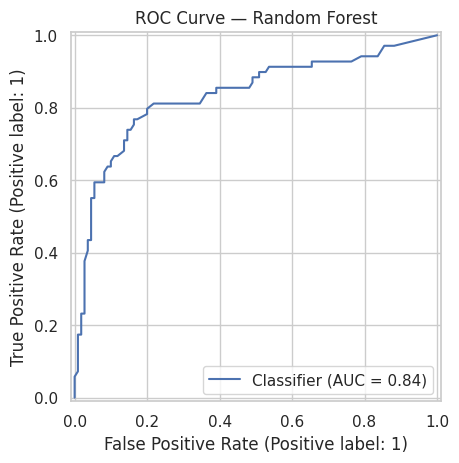

In [14]:
# Cell 14: ROC curve (Random Forest)
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

model = rf_pipeline
y_proba = model.predict_proba(X_test)[:,1]
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title('ROC Curve — Random Forest')
plt.show()


In [15]:
# Cell 15: Show misclassified examples for RandomForest
y_pred_rf = rf_pipeline.predict(X_test)
mis_idx = X_test.index[y_pred_rf != y_test]
mis_examples = X_test.loc[mis_idx].copy()
mis_examples['y_true'] = y_test.loc[mis_idx]
mis_examples['y_pred'] = y_pred_rf[y_pred_rf != y_test]
mis_examples.head(10)


,pclass,sex,age,sibsp,parch,fare,embarked,y_true,y_pred
553,3,male,22.0,0,0,7.2250,C,1,0
559,3,female,36.0,1,0,17.4000,S,1,0
536,1,male,45.0,0,0,26.5500,S,0,1
27,1,male,19.0,3,2,263.0000,S,0,1
712,1,male,48.0,1,0,52.0000,S,1,0
455,3,male,29.0,0,0,7.8958,C,1,0
489,3,male,9.0,1,1,15.9000,S,1,0
165,3,male,9.0,0,2,20.5250,S,1,0
297,1,female,2.0,1,2,151.5500,S,0,1
502,3,female,NaN,0,0,7.6292,Q,0,1
